In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.ticker import FormatStrFormatter

import cell_order_log_analysis

import sys
sys.path.append('../radio_api')
import mcs_mapper

In [2]:
FIG_SIZE = (5,4.5)
FONT_SIZE = 16
LINE_STYLE = (0,(4,4))
LINE_WIDTH = 2.5
SAVE_FIG = False

RESERVATION = 'RES130663'
reservation_data_dir = '../data/' + RESERVATION + '/'
cell_order_log_filename = reservation_data_dir + 'cell-order-increasingRbg-mcs9-3.log'

if (SAVE_FIG):
    reservation_out_dir = '../outputs/' + RESERVATION + '/'
    if (not os.path.exists(reservation_out_dir)):
        os.mkdir(reservation_out_dir)

SLA_PERIOD = 30 # seconds over which the SLAs are negotiated
OUTLIER_PERCENTILE = 5 # Percentile to clip-off from both ends for each SLA period

In [3]:
bs_data, slice_delay_budget_msec, ts_start = cell_order_log_analysis.read_cell_order_log(cell_order_log_filename)
cell_order_log_analysis.summarize_over_sla_period(bs_data, SLA_PERIOD, OUTLIER_PERCENTILE)

for s_idx, metrics in bs_data.items():
    bs_data[s_idx]['raw_expected_tx_mbps'] = []
    for i in range(metrics['raw_ts_sec'].size):
        expected_thp = mcs_mapper.calculate_thp_mbps(int((metrics['raw_mcs'][i])),
                                                     int(metrics['raw_n_rbgs'][i]))
        bs_data[s_idx]['raw_expected_tx_mbps'].append(expected_thp)
    bs_data[s_idx]['raw_expected_tx_mbps'] = np.array(bs_data[s_idx]['raw_expected_tx_mbps'])

    bs_data[s_idx]['raw_n_rbgs'][0] = 1

    active_slice = list(bs_data.keys())[0]

Data for 479.731999874115 seconds has been extracted


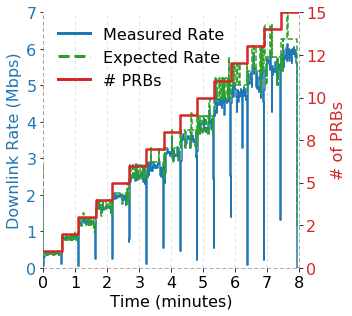

In [4]:
fig, ax1 = plt.subplots(figsize=FIG_SIZE)

color = 'C0'
ax1.set_xlabel('Time (minutes)', fontsize=FONT_SIZE)
ax1.set_ylabel('Downlink Rate (Mbps)', color=color, fontsize=FONT_SIZE)
# ln1 = plt.step(np.insert(bs_data[active_slice]['ts_sec'], 0, 0), 
#                np.insert(bs_data[active_slice]['tx_mbps'], 0, 0), 
#                where='pre', color=color, linestyle='--', label='30-sec Ave')
ln1 = plt.step(bs_data[active_slice]['raw_ts_sec'] / 60, 
               bs_data[active_slice]['raw_tx_mbps'], 
               where='pre', color=color, linestyle='-', label='Measured Rate')
ln2 = plt.step(bs_data[active_slice]['raw_ts_sec'] / 60, 
               bs_data[active_slice]['raw_expected_tx_mbps'], 
               where='pre', color='C2', linestyle='--', label='Expected Rate')
ax1.tick_params(axis='y', labelcolor=color, labelsize=FONT_SIZE)
ax1.tick_params(axis='x', labelsize=FONT_SIZE)
ax1.set_ylim((0, 7))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'C3'
ax2.set_ylabel('# of PRBs', color=color, fontsize=FONT_SIZE)
ln3 = plt.step(bs_data[active_slice]['raw_ts_sec'] / 60, 
               bs_data[active_slice]['raw_n_rbgs'], 
               where='pre', color=color, label='# PRBs', linewidth=LINE_WIDTH)
ax2.tick_params(axis='y', labelcolor=color, labelsize=FONT_SIZE)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
ax2.set_ylim((0, 15))

lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
leg= ax2.legend(lns, labs, loc='upper left', frameon=False, 
                fontsize=FONT_SIZE, ncol=1)
for line in leg.get_lines():
    line.set_linewidth(3)

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.grid(axis='x', alpha=0.5, linestyle=LINE_STYLE)
ax2.grid(axis='x', alpha=0.5, linestyle=LINE_STYLE)

plt.xlim([0,8])
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start, end+1))

ax1.spines["right"].set_linestyle(LINE_STYLE)
ax1.spines["right"].set_alpha(0.5)
ax1.spines["right"].set_color('gray')
ax1.spines["left"].set_linestyle(LINE_STYLE)
ax1.spines["left"].set_alpha(0.5)
ax1.spines["left"].set_color('gray')
ax1.spines["top"].set_linestyle(LINE_STYLE)
ax1.spines["top"].set_alpha(0.5)
ax1.spines["top"].set_color('gray')
ax1.spines["bottom"].set_linestyle(LINE_STYLE)
ax1.spines["bottom"].set_alpha(0.5)
ax1.spines["bottom"].set_color('gray')
ax2.spines["right"].set_linestyle(LINE_STYLE)
ax2.spines["right"].set_alpha(0.5)
ax2.spines["right"].set_color('gray')
ax2.spines["left"].set_linestyle(LINE_STYLE)
ax2.spines["left"].set_alpha(0.5)
ax2.spines["left"].set_color('gray')
ax2.spines["top"].set_linestyle(LINE_STYLE)
ax2.spines["top"].set_alpha(0.5)
ax2.spines["top"].set_color('gray')
ax2.spines["bottom"].set_linestyle(LINE_STYLE)
ax2.spines["bottom"].set_alpha(0.5)
ax2.spines["bottom"].set_color('gray')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

if SAVE_FIG:
    plt.savefig(reservation_out_dir + 'rate_and_prbs.pdf')

plt.show()

Correlation: 0.9457941088918222


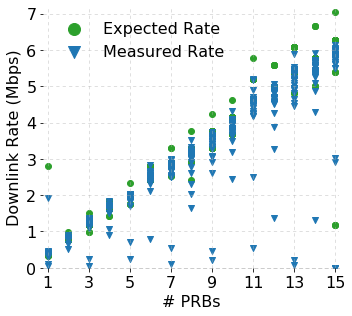

In [5]:
fig, ax1 = plt.subplots(figsize=FIG_SIZE)

ax1.set_xlabel('# PRBs', fontsize=FONT_SIZE)
ax1.set_ylabel('Downlink Rate (Mbps)', fontsize=FONT_SIZE)

plt.scatter(bs_data[active_slice]['raw_n_rbgs'], 
            bs_data[active_slice]['raw_expected_tx_mbps'], 
            color='C2', label='Expected Rate', marker='o')
plt.scatter(bs_data[active_slice]['raw_n_rbgs'], 
            bs_data[active_slice]['raw_tx_mbps'], 
            color='C0', label='Measured Rate', marker='v')


ax1.tick_params(axis='y', labelsize=FONT_SIZE)
ax1.tick_params(axis='x', labelsize=FONT_SIZE)
ax1.set_ylim((0, 7.2))
ax1.yaxis.set_ticks(np.arange(0, 8))
ax1.set_xlim([0.8,15.2])
ax1.xaxis.set_ticks(np.arange(1, 16, 2))

ax1.legend(loc='upper left', frameon=False, fontsize=FONT_SIZE, markerscale=2)

ax1.grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines["right"].set_linestyle(LINE_STYLE)
ax1.spines["right"].set_alpha(0.5)
ax1.spines["right"].set_color('gray')
ax1.spines["left"].set_linestyle(LINE_STYLE)
ax1.spines["left"].set_alpha(0.5)
ax1.spines["left"].set_color('gray')
ax1.spines["top"].set_linestyle(LINE_STYLE)
ax1.spines["top"].set_alpha(0.5)
ax1.spines["top"].set_color('gray')
ax1.spines["bottom"].set_linestyle(LINE_STYLE)
ax1.spines["bottom"].set_alpha(0.5)
ax1.spines["bottom"].set_color('gray')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

if SAVE_FIG:
    plt.savefig(reservation_out_dir + 'rate_vs_prbs.pdf')

print('Correlation: {}'.format(np.corrcoef(bs_data[active_slice]['raw_expected_tx_mbps'],
                                           bs_data[active_slice]['raw_tx_mbps'])[0,1]))

plt.show()